In [ ]:
# MN across species

In [2]:
library(SingleCellExperiment)
library(MetaNeighbor)
library(Seurat)
library(dplyr)

In [4]:
# load integrated data
sc1 = readRDS('chicken/chicken_integrated_ssSTACAS.rds')
mat1 = sc1@assays$RNA@counts
mtd1 = sc1@meta.data
mtd1$stage = sc1$orig.ident

tab1 = read.delim('chicken/chicken_ssSTACAS_celltypes.txt', sep = '\t')
mtd1$broad_type = tab1$subtype[match(sc1$seurat_clusters, tab1$cluster)]
mtd1$cluster = tab1$label[match(sc1$seurat_clusters, tab1$cluster)]


sc2 = readRDS('turtle/turtle_integrated_ssSTACAS.rds')
mat2 = sc2@assays$RNA@counts
mtd2 = sc2@meta.data
mtd2$stage = sc2$orig.ident

tab2 = read.delim('turtle/turtle_ssSTACAS_celltypes.txt', sep = '\t')
mtd2$broad_type = tab2$subtype[match(sc2$seurat_clusters, tab2$cluster)]
mtd2$cluster = tab2$label[match(sc2$seurat_clusters, tab2$cluster)]


sc3 = readRDS('lizard/lizard_integrated_ssSTACAS.rds')
mat3 = sc3@assays$RNA@counts
mtd3 = sc3@meta.data
mtd3$stage = sc3$orig.ident

tab3 = read.delim('lizard/lizard_ssSTACAS_celltypes.txt', sep = '\t')
mtd3$broad_type = tab3$subtype[match(sc3$seurat_clusters, tab3$cluster)]
mtd3$cluster = tab3$label[match(sc3$seurat_clusters, tab3$cluster)]

In [5]:
# get orthologs
om1 = read.delim('turtle/turtle_chicken_orthologs_biomart.txt', sep = '\t')
om1 <- om1[which(om1[,1]!='' & om1[,2]!='' & !is.na(om1[,5]) & om1[,5]==1 & om1[,4]=='ortholog_one2one'),]
om1[1,]

om2 = read.delim('lizard/lizard_chicken_orthologs_eggNOG.txt', sep = '\t')
om2 <- om2[which(!is.na(om2$lizard_gene) & !is.na(om2$ortholog_name)),]
om2 <- om2[,c('lizard_gene', 'ortholog_name')]
dim(om2)
om2[1,]

Gene.name Chicken.gene.name Last.common.ancestor.with.Chicken
10 ND2       ND2               Archelosauria                    
   Chicken.homology.type Chicken.orthology.confidence..0.low..1.high.
10 ortholog_one2one      1

[1] 25708     2

lizard_gene ortholog_name
1 ARHGEF10    ARHGEF10

In [6]:
# rename to chicken gene names
rownames(mat2) <- om1[match(rownames(mat2), om1[,1]),2]
mat2 <- mat2[!is.na(rownames(mat2)),]
dim(mat2)

rownames(mat3) <- om2[match(rownames(mat3), om2[,1]),2]
mat3 <- mat3[!is.na(rownames(mat3)),]
dim(mat3)

[1] 10505 68775

In [8]:
# subset to common orthologs
common_genes = intersect(rownames(mat3), intersect(rownames(mat1), rownames(mat2)))
mat1 <- mat1[common_genes,]
mat2 <- mat2[common_genes,]
mat3 <- mat3[common_genes,]

In [12]:
# get metadata
cols1 = c('species', 'stage', 'cluster')

# make SCE object
sce = SingleCellExperiment(list(counts = cbind(mat1, mat2, mat3)),
                           colData = DataFrame(rbind(mtd1[,cols1], mtd2[,cols1], mtd3[,cols1])))
sce$species_stage = paste0(sce$species, '-', sce$stage)
sce

class: SingleCellExperiment 
dim: 8637 195030 
metadata(0):
assays(1): counts
rownames(8637): IFT52 LRFN5 ... TSHZ3 ZNF536
rowData names(0):
colnames(195030): stage23_sample3_AAACCCAAGTAACAGT-1
  stage23_sample3_AAACCCACAACAGAGC-1 ...
  stage16_sample3_TTTGTTGGTTCCTACC-1 stage16_sample3_TTTGTTGTCAGTGTTG-1
colData names(4): species stage cluster species_stage
reducedDimNames(0):
mainExpName: NULL
altExpNames(0):

In [13]:
options(warn = -1)
start.time <- Sys.time()
hvg = variableGenes(sce, exp_labels = sce$species_stage)
length(hvg)

# defaults to top 95% of genes. May need to vary
end.time <- Sys.time()
time.taken <- end.time - start.time
time.taken

# get top 2k hvgs
if(length(hvg)>2000){
    hvg <- sample(hvg, 2000, replace = F)
}

[1] 656

Time difference of 31.13838 secs

In [14]:
# MN scores
options(warn = -1)
aurocsall = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$species_stage, 
    cell_type = sce$cluster, fast_version = TRUE, one_vs_best = FALSE,
    symmetric_output = TRUE)

aurocs1v1 = MetaNeighborUS(var_genes = hvg, dat = sce, study_id = sce$species_stage, 
    cell_type = sce$cluster, fast_version = TRUE, one_vs_best = TRUE,
    symmetric_output = TRUE)

In [21]:
# plot heatmaps #
exps = sub('\\|.*', '', rownames(aurocsall))
ctypes = sub('.*\\|', '', rownames(aurocsall))

subs3 = c('aCM', 'LV_vCM', 'RV_vCM', 'immature_CM', 'blood', 
          'macrophage', 'mes_progenitor', 'endocardial',
          'epicardial', 'fibroblast', 'SMC', 'neural_crest')
subcol3 = c('#fd91a0', '#ed2939', '#ff6361', '#fc6a03', '#d68a58', 
            '#eddfc9', '#03ac13', '#255d8d',
            '#499fcd', '#c2d87a', '#fece52', '#829aed')


reg2 = c(paste0('chicken-', c('stage23', 'stage28', 'stage32')),
        paste0('turtle-', c('stage14', 'stage17', 'stage21')),
        paste0('lizard-', c('stage9', 'stage13', 'stage16')))

regcols2 = rep(c('#fda638', '#eb7c69', '#459395'), each = 3)


cols1 = subcol3[match(ctypes, subs3)]  # for consensus

cols2 = regcols2[match(exps, reg2)]

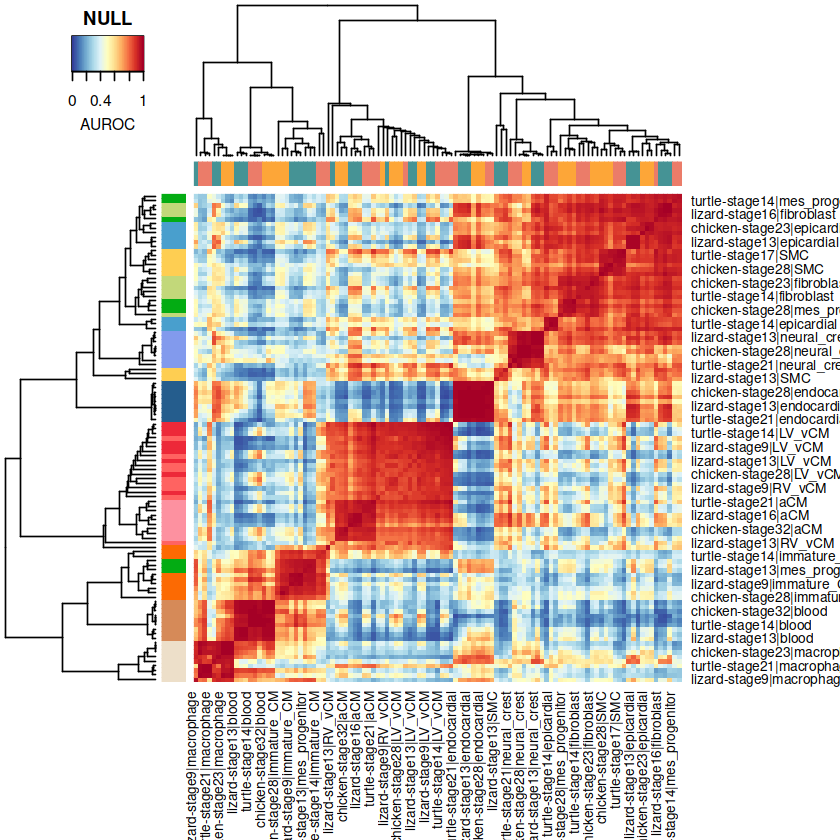

In [24]:
# png(paste0('aa_stacas_chicken_MN.png'), width = 15, height = 15, res = 300, units = 'in')
# pdf('aa-chicken-mn-all-spe.pdf', width = 10, height = 10)
plotHeatmap(aurocsall, ColSideColors = cols2, RowSideColors = cols1, margins = c(10,10))
# dev.off()

In [32]:
em1 = extractMetaClusters(aurocs1v1, threshold = 0)
graph1 = makeClusterGraph(aurocs1v1)

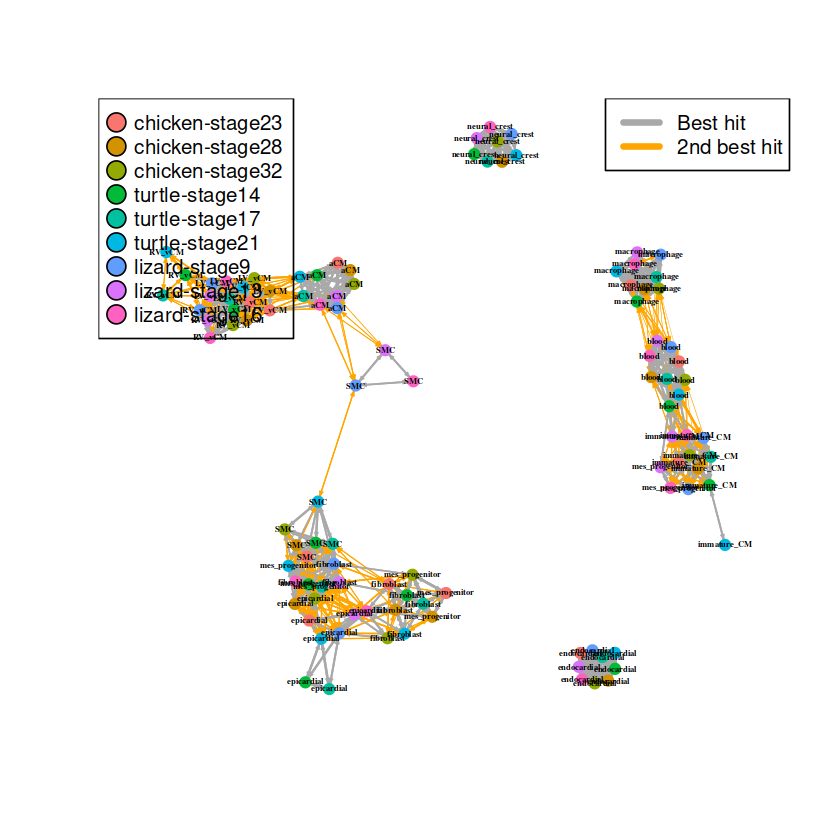

In [36]:
# pdf('aaa-clustergraph.pdf', width = 5, height = 5)
plotClusterGraph(graph1, size_factor = 2)
# dev.off()

In [23]:
# get top hits
tops = topHits(aurocsall, dat = sce, study_id = sce$species_stage, cell_type = sce$cluster, threshold = 0.9)
tops$species1 = sub('\\-.*', '', tops[,1])
tops$species2 = sub('\\-.*', '', tops[,2])
tops[tops$species1!=tops$species2,]

Study_ID|Celltype_1          Study_ID|Celltype_2           Mean_AUROC
12 chicken-stage32|neural_crest turtle-stage17|neural_crest   1.00      
20 lizard-stage13|endocardial   turtle-stage21|endocardial    0.99      
36 turtle-stage21|LV_vCM        lizard-stage16|LV_vCM         0.97      
43 turtle-stage21|LV_vCM        lizard-stage9|LV_vCM          0.97      
46 chicken-stage32|macrophage   lizard-stage13|macrophage     0.97      
51 turtle-stage21|LV_vCM        chicken-stage32|LV_vCM        0.97      
52 lizard-stage9|fibroblast     turtle-stage21|mes_progenitor 0.97      
55 lizard-stage9|fibroblast     turtle-stage17|mes_progenitor 0.96      
57 lizard-stage16|epicardial    turtle-stage21|fibroblast     0.96      
58 turtle-stage21|LV_vCM        chicken-stage32|RV_vCM        0.96      
61 chicken-stage23|fibroblast   turtle-stage14|fibroblast     0.95      
66 turtle-stage21|LV_vCM        chicken-stage28|LV_vCM        0.94      
67 turtle-stage21|LV_vCM        lizard-stage16|RV_vCM         0.94      
68 turtle-stage21|LV_vCM        chicken-stage23|RV_vCM        0.93      
70 turtle-stage21|LV_vCM        chicken-stage23|LV_vCM        0.93      
73 lizard-stage16|immature_CM   turtle-stage17|immature_CM    0.93      
75 turtle-stage17|LV_vCM        lizard-stage9|RV_vCM          0.92      
   Match_type species1 species2
12 Above_0.9  chicken  turtle  
20 Above_0.9  lizard   turtle  
36 Above_0.9  turtle   lizard  
43 Above_0.9  turtle   lizard  
46 Above_0.9  chicken  lizard  
51 Above_0.9  turtle   chicken 
52 Above_0.9  lizard   turtle  
55 Above_0.9  lizard   turtle  
57 Above_0.9  lizard   turtle  
58 Above_0.9  turtle   chicken 
61 Above_0.9  chicken  turtle  
66 Above_0.9  turtle   chicken 
67 Above_0.9  turtle   lizard  
68 Above_0.9  turtle   chicken 
70 Above_0.9  turtle   chicken 
73 Above_0.9  lizard   turtle  
75 Above_0.9  turtle   lizard

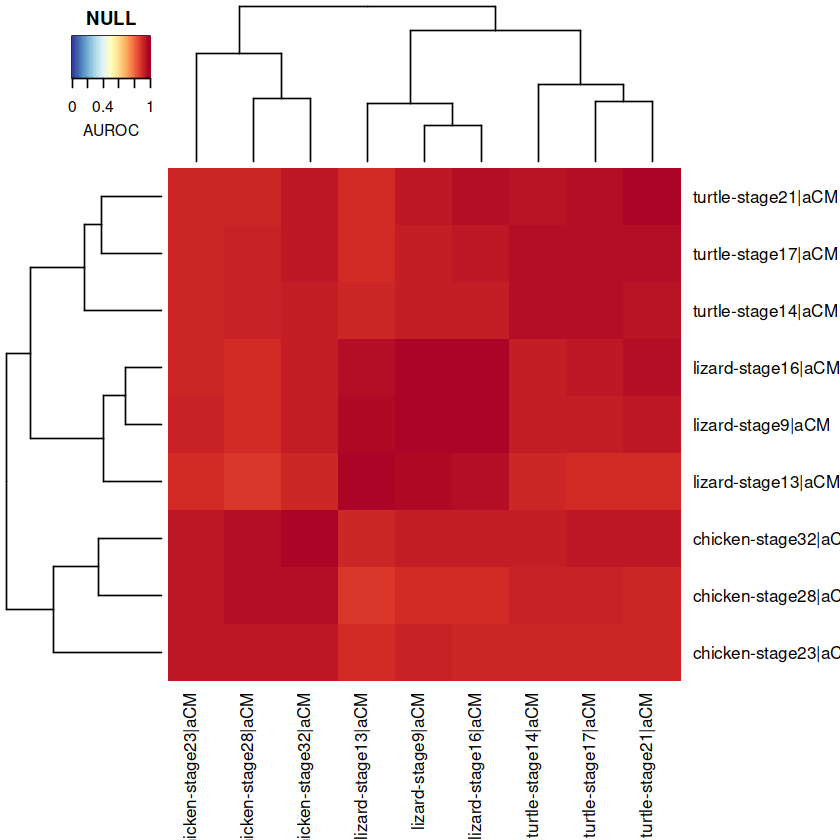

In [28]:
ids = grep('aCM', ctypes)

currmat = aurocsall[ids,ids]

plotHeatmap(currmat)